<h1 style="text-align:center;text-decoration: underline">Astronomy 350 Final Project</h1>

Prof. Quimby <br>
Spring 2025 <br>
**Steps 1-4 Due May 7 at 5pm** <br>
**Steps 5-7 (including the written report) due May 13 at 5pm**

**Student Name:**

## Process (continued from Part 1)

In [56]:
# some packages and functions you might need
import os
import numpy as np
import astropy.units as u
from scipy.optimize import fmin

from photutils.aperture import CircularAperture, aperture_photometry
from astropy.io import fits
from astropy import wcs
from astropy.stats import sigma_clip
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
Vizier.ROW_LIMIT = -1

%matplotlib inline
import matplotlib.pyplot as plt

# silence VO table warnings
import warnings
warnings.filterwarnings("ignore", module='astropy.io.votable.tree')

### Load the `data` created in Steps 1-4

In [57]:
import pickle
datafile = 'NGC2323_phot.pkl' # name of the file to load
data = pickle.load( open(datafile, 'rb') )

### Step 5
Use the Gaia parallax and proper motion measurements to determine which of the stars are (isolated) cluster members.

Some of the stars in the field belong to the cluster and some do not. We need to identify which are most likely cluster members by considering the distance and proper motion distributions of these stars. Stars in the cluster should be at a similar distance, where "similar" accounts for the fact that the cluster may extend over hundreds of parsecs. If the stars formed from the same cloud of gas then we can also expect they should have similar proper motion values. By identifying clumps in distance and proper motion distributions, we can separate true cluster members from interloping field stars.

We also need to identify which of the stars are isolated such that light from neighboring objects does not interfere with the MLO 1.0m photometry. To do this, you can pick the stars that have no neighbors within 10 arcseconds. 

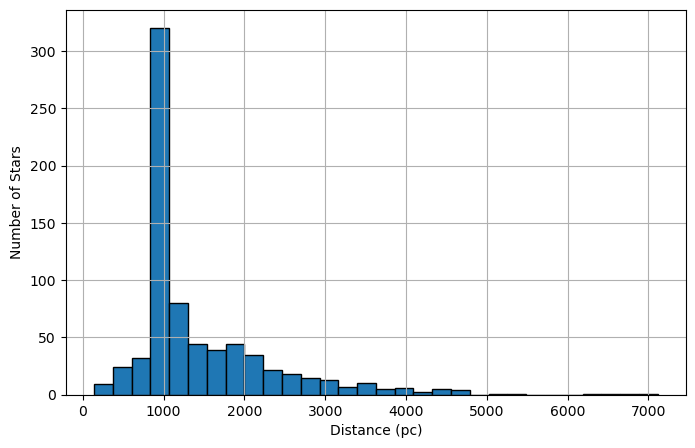

dtype([('id', '<U24'), ('ra', '<f8'), ('dec', '<f8'), ('distance', '<f8'), ('edistance', '<f8'), ('pmra', '<f8'), ('pmdec', '<f8'), ('Bmag_cat', '<f8'), ('Vmag_cat', '<f8'), ('Bmag', '<f8'), ('eBmag', '<f8'), ('Vmag', '<f8'), ('eVmag', '<f8')])

In [58]:
# plot a histogram of the Gaia distances to each star in the field

plt.figure(figsize = (8,5))
plt.hist(data['distance'], bins=30, edgecolor='black')
plt.xlabel('Distance (pc)')
plt.ylabel('Number of Stars')
plt.grid()
plt.show()
data.dtype


In [59]:
# choose minimum and maximum distances to define the cluster
dmin = 800
dmax = 1300

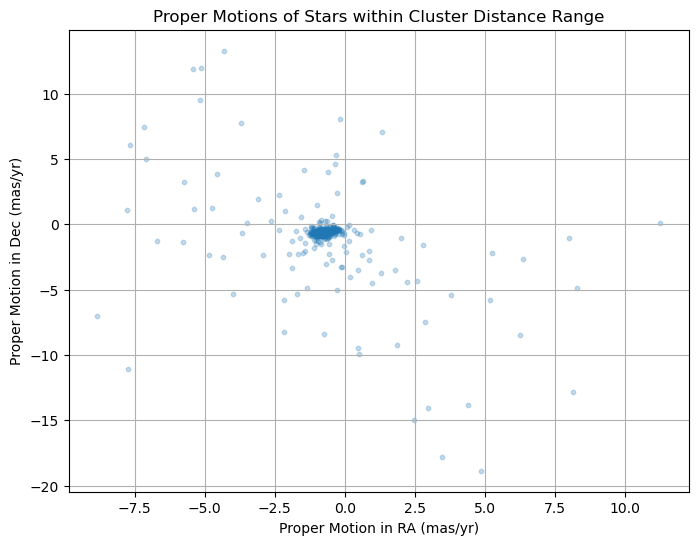

In [60]:
# plot the proper motions of stars within dmin and dmax
# (make sure to zoom in to identify the clump limits in both ra and dec)
candidates = data[(data['distance'] >= dmin) & (data['distance'] <= dmax)]
plt.figure(figsize=(8,6))
plt.scatter(candidates['pmra'], candidates['pmdec'], s=10, alpha=0.25)
plt.xlabel('Proper Motion in RA (mas/yr)')
plt.ylabel('Proper Motion in Dec (mas/yr)')
plt.title('Proper Motions of Stars within Cluster Distance Range')
plt.grid()
plt.show()


In [61]:
# choose minimum and maximum proper motion values
pmra_min = -1.5
pmra_max = 1.5
pmdec_min = -1.5
pmdec_max = 1.5

In [62]:
# define cluster membership truth array
is_cluster = (data['distance'] >= dmin) & (data['distance'] <= dmax) & (data['pmra'] >= pmra_min) & (data['pmra'] <= pmra_max) & (data['pmdec'] >= pmdec_min) & (data['pmdec'] <= pmdec_max)


In [63]:
# identify isolated stars
inds = np.arange(len(data))
coords = SkyCoord(data['ra'], data['dec'], unit='deg')
tol = 10 * u.arcsec
is_isolated = np.zeros(len(data), dtype=bool)
for i in np.arange(len(data)):
    others = inds != i
    
    # angular separations between this star and all other stars
    sep = coords[i].separation(coords[others])
    
    w = (sep < tol)
    if w.sum() == 0:
        is_isolated[i] = True

# now `is_isolated` should be a truth array indicating if a star is isolated or not

### Step 6
Compare your data to model predictions to determine the best Age and E(B-V) for the cluster through chi-square minimization.

As mentioned in the Background, the mass of a star at birth largely determines the color and brightness that the star will shine at for most of its life, how long the star will shine, and how it will change in color and brightness as it runs out of fuel. Theorists (e.g., [Bressan et al. 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427..127B/abstract)) have developed models to describe this evolution, and it is possible to create simulated populations of stars, all created from the same hypothetical cloud of gas at the same time. These models can be used to predict how the color and magnitudes of stars in a cluster will change with age.

Included in this repo is a file, `iso_pop_models.dat`, that contains the expected B and V-band **absolute** magnitudes for simulated populations of stars at different ages (note the "age" column is actually **log(Age in yr)**, so "7" would be 10,000,000 years). These models were downloaded from the [CMD web interface](http://stev.oapd.inaf.it/cgi-bin/cmd). You should first load in these model values and make some plots to see how the colors and magnitudes of stars in a cluster are predicted to change with age.

You will compare the model predictions to the B-V colors and V-band magnitudes of the stars in your cluster. Recall that observed magnitudes depend on the intrinsic luminosity, distance, and absorption from any dust or gas along the line of sight. The color of a star does not depend on distance, but shorter wavelengths are more likely to be absorbed by gas and dust. Thus star light is both diminished and "reddened" by gas and dust.

You can use $\chi^2$ minimization to determine the age and extinction of your cluster given the isochrone population models and your observed magnitudes. For a given age and color excess, E(B-V), you can determine a $\chi^2$ value using the B-V color and absolute V-band magnitude in the model population that best matches each of your observed stars after converting the observed magnitudes to absolute magnitudes and intrinsic colors according to the known distance and assumed E(B-V). Assume the standard $R_V = 3.1$ and note that the B-band to V-band absorption ratio is $A_B / A_V = 1.297$.

In [64]:
# load the isochrone population models
filename = 'iso_pop_models.dat'
pdata = np.genfromtxt(filename, dtype=None, names=True, encoding='utf-8')
pdata

array([(0.015, 7. , 7.226, 6.105), (0.015, 7. , 3.938, 3.335),
       (0.015, 7. , 4.008, 3.394), ..., (0.015, 9.9, 6.753, 5.902),
       (0.015, 9.9, 9.152, 7.893), (0.015, 9.9, 8.192, 7.099)],
      dtype=[('Z', '<f8'), ('age', '<f8'), ('Bmag', '<f8'), ('Vmag', '<f8')])

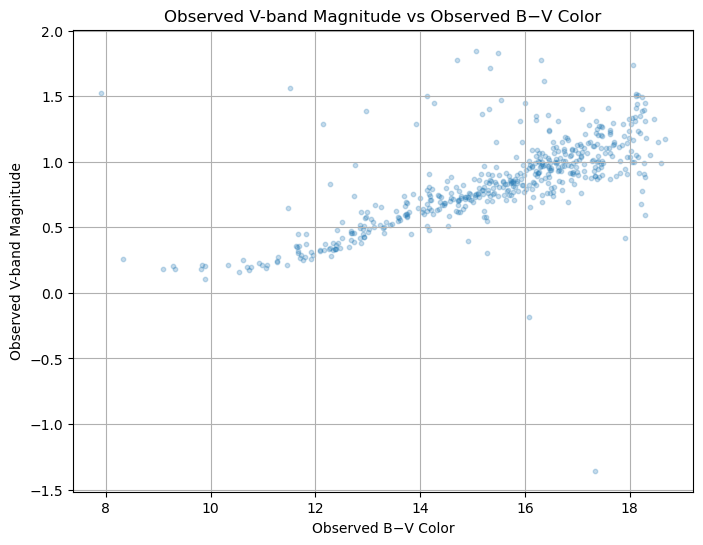

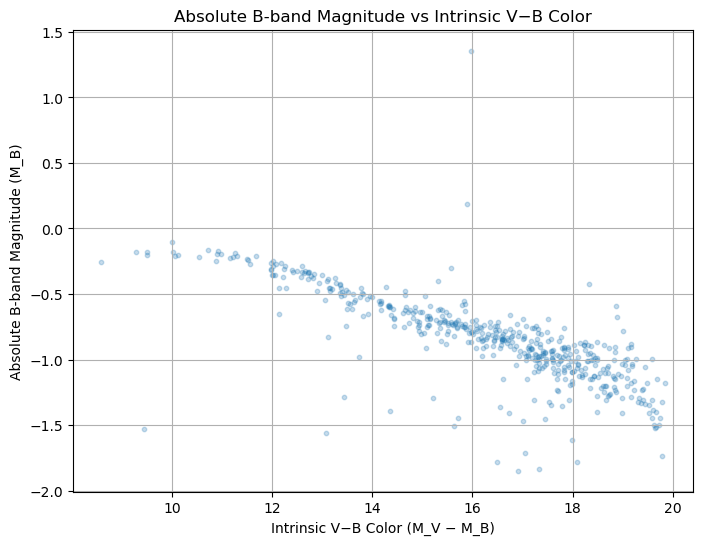

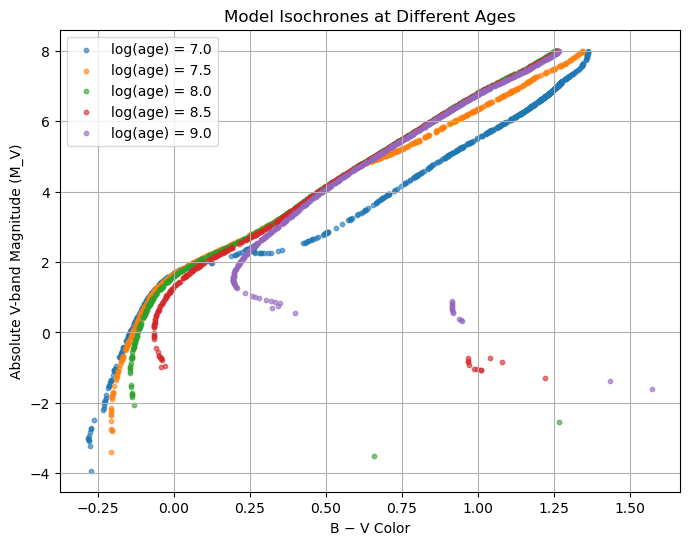

In [85]:
# plot a few models with different ages to see 
# the evolution in color and magnitude space
# (i.e. plot M_V vs. M_B - M_V)
plt.figure(figsize=(8,6))
plt.scatter(data['Vmag'], data['Bmag'] - data['Vmag'], s=10, alpha=0.25)
plt.title('Observed V-band Magnitude vs Observed B−V Color')
plt.xlabel('Observed B−V Color')
plt.ylabel('Observed V-band Magnitude')
plt.grid()

plt.figure(figsize=(8,6))
plt.scatter(data['Bmag'], data['Vmag'] - data['Bmag'], s=10, alpha=0.25)
plt.title('Absolute B-band Magnitude vs Intrinsic V−B Color')
plt.xlabel('Intrinsic V−B Color (M_V − M_B)')
plt.ylabel('Absolute B-band Magnitude (M_B)')
plt.grid()

example_ages = [7.0, 7.5, 8.0, 8.5, 9.0]  # log(age) in years

plt.figure(figsize=(8, 6))

for age in example_ages:
    model = pdata[pdata['age'] == age]
    M_V = model['Vmag']
    color = model['Bmag'] - model['Vmag']
    plt.scatter(color, M_V, label=f'log(age) = {age}', s=10, alpha=0.6)

plt.gca().invert_yaxis()  # because lower magnitudes are brighter
plt.xlabel('B − V Color')
plt.ylabel('Absolute V-band Magnitude (M_V)')
plt.title('Model Isochrones at Different Ages')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
#plt.savefig('Isochrones_Ages.pdf')
plt.show()

In [73]:
def get_chisq(ebmv, data, iso_pop):
    """
    return the chi-squared value for the given model and color excess
    
    ebmv - the color excess, E(B-V), as a float
    data - numpy structured array with the observed magnitudes, 
           distances, and uncertainties
    iso_pop - numpy structured array with the absolute magintudes
              for each star in the (single age) model population
    """

    if ebmv < 0:
        # color excess cannot be negative!
        return np.inf
    
    # model values
    modelmags = iso_pop['Vmag'] # Absolute V-band magnitudes of the model stars
    modelcolors = iso_pop['Bmag'] - iso_pop['Vmag']  # B - V color of the model stars
   
    # V-band absorption for each observed star
    A_V = 3.1 * ebmv 

    # determine the contribution to the chi-square from each star
    chisq_contributions = []
    for star in data:
        # convert observed magnitude to absolute magnitude
        mu = 5 * np.log10(star['distance']) - 5 # distance modulus of this star
        M_B = star['Bmag'] - mu - 1.297 * A_V # Absolute B-band magnitude of this star
        M_V =  star['Vmag'] - mu - A_V # Absolute V-band magnitudes of this star
        color = M_B - M_V

        # calculate uncertainty in V-band magnitude
        eM_V = star['eVmag']
        
        # calculate uncertainty in B-V color 
        # (hint: color is independent of distance!)
        ecolor = np.hypot(star['eBmag'], star['eVmag'])

        # find the model point with the least absolute pull 
        # (pull is the residual divided by the uncertainty)
        pulls = np.hypot( (color - modelcolors) / ecolor, (M_V - modelmags) / eM_V )
        minpull = pulls.min()
        
        # store the chi-squared contribution from this star
        chisq_contributions.append(minpull**2)
    
    return np.sum(chisq_contributions)

In [74]:
# using only data for stars that are in the cluster, isolated, 
# and have both B and V-band measured magnitudes, find the 
# best-fit cluster age and E(B-V) through chi-sq minimization
# (hint: brute-force every model age and *many* E(B-V) values
# in the range 0 < E(B-V) < 1.0 )
best_chisq = np.inf
best_age = None
best_ebv = None 

mask = is_cluster & is_isolated & ~np.isnan(data['Bmag']) & ~np.isnan(data['Vmag'])
filtered = data[mask]

unique_ages = np.unique(pdata['age'])

ebv_values = np.linspace(0.0, 1.0, 100)

for age in unique_ages:
    # Get the model stars at this age
    iso_pop = pdata[pdata['age'] == age]

    for ebv in ebv_values:
        chisq = get_chisq(ebv, filtered, iso_pop)

        if chisq < best_chisq:
            best_chisq = chisq
            best_age = age
            best_ebv = ebv
            
print(f'Best-fit age: {best_age}')
print(f'Best-fit E(B-V): {best_ebv:.3f}')
print(f'Min chi-squared: {best_chisq:.2f}')

Best-fit age: 7.9
Best-fit E(B-V): 0.404
Min chi-squared: 2575.60


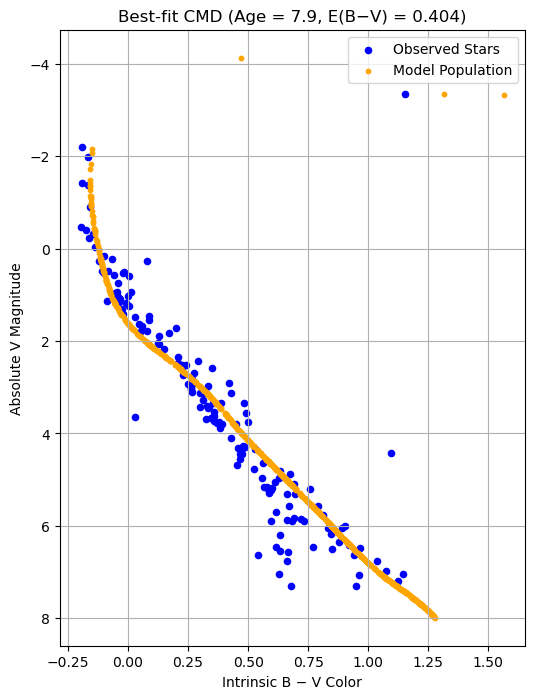

In [87]:
# use your best-fit E(B-V) to plot the absolute V-band magnitudes
# of your stars vs *intrinsic* B-V color, and compare to the
# model population of the best-fit age
R_V = 3.1
A_V = R_V * best_ebv
A_B = 1.297 * A_V

mu = 5* np.log10(filtered['distance']) - 5
M_V = filtered['Vmag'] - mu - A_V
M_B = filtered['Bmag'] - mu - A_B
col = M_B - M_V

model_data = pdata[pdata['age'] == best_age]
model_col = model_data['Bmag'] - model_data['Vmag']
model_MV = model_data['Vmag']

plt.figure(figsize=(6, 8))
plt.scatter(col, M_V, label='Observed Stars', color='blue', s=20)
plt.scatter(model_col, model_MV, label='Model Population', color='orange', s=10)
plt.gca().invert_yaxis()  # Magnitude scale: lower is brighter
plt.xlabel('Intrinsic B − V Color')
plt.ylabel('Absolute V Magnitude')
plt.title(f'Best-fit CMD (Age = {best_age}, E(B−V) = {best_ebv:.3f})')
plt.legend()
plt.grid()
#plt.savefig('BestFitCMD.pdf')
plt.show()

### Step 7

Present your results in an ApJ style paper that you write using $\LaTeX$. You should use [Overleaf](https://www.overleaf.com/) to prepare your paper. You must include figures and citations and properly reference these in the main text.

The paper should demonstrate your understanding of how you measure the distance, age, and color excess to your target and include a discussion of how you use your data and $\chi^2$ fitting techniques to derive your measurements. Sections of the paper should include:
   * *Abstract*: a concise statement of the paper's objective, key methods, main results, and impact.
   * *Introduction*: provide background information on the material covered in the paper. This section typically begins with motivation for the current work (e.g. "it is important to know X because Y, but it is hard to know X because..."). Introductions should also give the reader a guide of what is to come in later sections.
   * *Data*: explain where the data used in the paper come from and specifically point out anything about the data that may affect the precision or accuracy of the results.
   * *Analysis*: this is where you take the available data, apply the techniques discussed in the introduction, and produce new measurements. Explain how you get from the data to the measurements.
   * *Discussion/Conclusions*: what are the implications of the Analysis? Summary of what has been learned. What are the limitations of the results? What could be done to improve the results?

Additionally, the paper should have a title, list the authors who contributed, and provide references. 